In [1]:
# Own Packages
from Masterarbeit_utils.model_utils import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer


# Site-Packages
import dask.dataframe as dd
import torch
import psutil
import os
import sys
import pickle as pk
import pandas as pd
import numpy as np
import bokeh
import time
import random
from matplotlib import pyplot as plt
from cProfile import Profile
from pstats import SortKey, Stats

# Dimension reduction algorithms
#from cuml.manifold import TSNE
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import export_png

from transformers import AutoTokenizer, OPTForCausalLM
from tokenizers.processors import TemplateProcessing
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

%matplotlib inline
output_notebook()

2023-08-29 15:24:46.455792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 15:24:46.568926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 15:24:47.159748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading BokehJS ...

In [2]:
"""
The Paths to important folders have to be changed for your system.
"""

# Name of this experiment
model_name = 'gal_125_aug_1'
checkpoint = 148000
# If True normalization is applied to the embeddings
norm = True
seq_class = False

if seq_class:
    # Importing code for sequence classification
    from Masterarbeit_utils.model_utils_seq_class import get_tokenizer, load_and_modify_model, load_pretrained_Tokenizer
    from transformers import OPTForSequenceClassification

# This folder will be created and filled with txt.files for each sample after you run the Pytorch Dataset Notebook
dataset_folder = f'data/dataset_samples'

# The folder at which the model will be saved. This folder has to be created for your system 
model_folder = f'data/models/{model_name}'
os.makedirs(model_folder, exist_ok=True)


# Folder in which the tokenizer will be saved
tokenizer_folder = f'data/tokenizers/{model_name}'
os.makedirs(tokenizer_folder, exist_ok=True)

# Folder at which all pickle files are stored. This folder is fixed for this project and should not be changed
dump_dir = r'PK_DUMP'

# Model parameters 
'''
mini	125 M
base	1.3 B
standard	6.7 B
large	30 B
huge	120 B'''
base_model_name = 'mini'

# All new Torch-objects will be by default in this dtype
# if default_type = float16 fp16 must be False
default_dtype = torch.float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_default_dtype(default_dtype)

# Default device on which the model will be loaded
default_device = 'cuda:0'

# Number of GPUs the model will be parallelised to 
num_gpus = 1
# If you change 'default_device' to 'cpu', make sure to set num_gpus to zero.
if default_device == 'cpu':
    num_gpus = 0

tensor_parallel = False


###########################
# Loading the Model
###########################
device_map=None
max_memory = {}
if num_gpus > 0:
    # based on https://github.com/huggingface/accelerate/blob/5315290b55ea9babd95a281a27c51d87b89d7c85/src/accelerate/utils/modeling.py#L274
    for i in range(num_gpus):
        _ = torch.tensor([0], device=i)
    for i in range(num_gpus):
        max_memory[i] = torch.cuda.mem_get_info(i)[0]
    device_map = "auto"
max_memory["cpu"] = psutil.virtual_memory().available

if seq_class:
    model = OPTForSequenceClassification.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)
else:
    model = OPTForCausalLM.from_pretrained(f'{model_folder}/checkpoint-{checkpoint}', torch_dtype=default_dtype, low_cpu_mem_usage=True,
                                               device_map=device_map, max_memory=max_memory)

###########################
# Loading the Tokenizer
###########################
tokenizer = AutoTokenizer.from_pretrained(tokenizer_folder)
n_f_terms = len(tokenizer) - tokenizer.vocab_size
print('Loaded Tokenizer from serialized instance!')    
print(f'There are {n_f_terms} different F-Terms in the whole Dataset!')


###########################
# Loading Descriptions
###########################
with open(f'{dump_dir}/themes_descriptions.pk', 'rb') as f:
    theme_dict = pk.load(f)
with open(f'{dump_dir}/viewpoints_descriptions.pk', 'rb') as f:
    viewpoint_dict = pk.load(f)
with open(f'{dump_dir}/numbers_descriptions.pk', 'rb') as f:
    number_dict = pk.load(f)
with open(f'{dump_dir}/full_descriptions.pk', 'rb') as f:
    full_descriptions_dict = pk.load(f)


###########################
# Extracting the Embeddings
###########################

# Extracting the classification Head weights
inp_emb = model.get_input_embeddings()

if not seq_class:
    #Embeddings if the model is not a sequence classification model
    out_emb = model.get_output_embeddings()
    out_emb = next(out_emb.parameters()).to('cpu').detach().numpy()[2:]
    inp_emb = inp_emb(torch.arange(len(tokenizer))).to('cpu').detach().numpy()[50002:]
    
    # Extracting context less embeddings
    if not os.path.isfile(f'{model_folder}/context_less_emb.pk'):
        print('Calculating context less embeddings!')
        context_less_emb = [[] for _ in range(13)]
        for i in range(len(tokenizer)):
            print(i, end='\r')
            out = model(input_ids= torch.tensor([[i]]), attention_mask = torch.tensor([[1]]), output_hidden_states=True)
            
            out = out.hidden_states
            for i, k in enumerate(out):
                context_less_emb[i].append(k.to('cpu').detach().numpy())
        with open(f'{model_folder}/context_less_emb.pk', 'wb') as f:
            pk.dump(context_less_emb, f)
    else:
        print('Loading context less embeddings from disk')
        with open(f'{model_folder}/context_less_emb.pk', 'rb') as f:
            context_less_emb = pk.load(f)
    
    # Combining context less embeddings of a layer to a single tensor
    for i, layer in enumerate(context_less_emb):
        layer = [e[0] for e in layer]
        layer = np.concatenate(layer, 0)
        context_less_emb[i] = layer

else: 
    # embeddings if the model is a Sequence Classifier
    inp_emb = inp_emb(torch.arange(50000)).to('cpu').detach().numpy()
    out_emb = model.score.weight
    out_emb.to('cpu').detach().numpy()
    

## Normalizing the embeddings 
def normalize(tensor):
    if norm:
        return torch.nn.functional.normalize(torch.tensor(tensor), p=2).numpy()
    else:
        return tensor

out_emb = normalize(out_emb)
inp_emb = normalize(inp_emb)
if not seq_class:
    context_less_emb = [normalize(layer) for layer in context_less_emb]

# Extracting the matching F_terms for the weights and creating lists with the defintions
tokens = [tokenizer.decode(i) for i in range(len(tokenizer))]
f_term_tokens = tokens[50002:]

# Creating  a dict with f-Terms and their embedding vectors:

out_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, out_emb)}
if seq_class:
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(tokens[:50000], inp_emb)}
else: 
    inp_emb_dict = {token[:-1]: vec for token, vec in zip(f_term_tokens, inp_emb)}
    
# Creating Context Less Embedding Dicts
if not seq_class:
    context_less_dicts = []
    for layer in context_less_emb:
        context_less_dicts.append({token[:-1]: vec for token, vec in zip(tokens, layer)})


####################################################
# Detecting F-Term Pairs with Supposed Similarities
####################################################
df=pd.read_csv("data/f-terms.csv", index_col=0)

#subset with "material" in the viewpoint description
df2=df[df.viewpoint_label.str.contains("material",case=False, na=False)].copy()
df2["vp"]=df2.theme+"/"+df2.viewpoint
df2["fterm"]=df2.theme+"/"+df2.number

#f-term descriptions are searched for the following materials
materials_list=["metal", "wood", "concrete", "resin", "fiber", "wool", "sand", "cord", "copper", "iron", "silver", "gold", "lead", "glass", "stone", "titanium", "steel", "cement", "silicon", "polymer", "ceramics"]
materials_f_terms={}
for material in materials_list:
    materials_f_terms[material]=[df2[df2.label.str.contains(material,case=False, na=False)].vp.unique(), df2[df2.label.str.contains(material,case=False, na=False)].fterm.values]

#pairs of two materials with fterms in same viewpoints are created
material_combinations={}
for mat1 in materials_list:
    for mat2 in materials_list:
        
        if mat1==mat2: continue
        if mat2+"_"+mat1 in materials_f_terms: continue
        
        #filtering shared f-terms with both materials in the label description
        
        unique_fterms_mat1 = list(set(materials_f_terms[mat1][1]) - set(materials_f_terms[mat2][1]))
        unique_fterms_mat2 = list(set(materials_f_terms[mat2][1]) - set(materials_f_terms[mat1][1]))


        vp_mat1= set([x[:8]for x in unique_fterms_mat1])
        vp_mat2= set([x[:8]for x in unique_fterms_mat2])
        shared_vp=[x for x in vp_mat1 if x in vp_mat2]
        fterm_pairs=[]
        for vp in shared_vp:
            fterm_pairs.append([vp,
                                [fterm for fterm in unique_fterms_mat1 if fterm.startswith(vp)],
                                [fterm for fterm in unique_fterms_mat2 if fterm.startswith(vp)]])
            
            
        material_combinations[mat1+"_"+mat2]=fterm_pairs

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loaded Tokenizer from serialized instance!
There are 378166 different F-Terms in the whole Dataset!
Loading context less embeddings from disk


# Plotting Context Less Embeddings

In [ ]:
# Calculating or loading the TSNE Representations for all Tokens (Text and F-Terms)

layer_tsne_reps = []
for i, emb in enumerate(context_less_emb):
    if os.path.isfile(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk'):
        print('Loading TSNE representation for layer ', i)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'rb') as f:
            layer_tsne_reps.append(pk.load(f))
    else:
        print('Calculating TSNE representation for layer ', i)
        tsne = TSNE(n_components=2, verbose=0, random_state=69) 
        tsne_rep = tsne.fit_transform(emb)
        with open(f'{model_folder}/output_tsne_rep_{checkpoint}_layer{i}.pk', 'wb') as f:
                pk.dump(tsne_rep, f)

In [ ]:
layer = 12
colors = []
for i in range(len(tokenizer)):
    if i < 50000:
        colors.append('blue')
    else: 
        colors.append('red')
        
datasource = ColumnDataSource(
        data=dict(
            x = layer_tsne_reps[layer][:,0],
            y = layer_tsne_reps[layer][:,1],
            tokens = [tokenizer.decode(i) for i in range(len(tokenizer))],
            colors = colors
        )
    )
    
hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>Token:</b> @tokens</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title=f'Context less Embeddings Layer {layer}')
        
plot_tsne.circle('x', 'y', size=8, fill_color='colors', 
                 alpha=0.7, line_width=0, source=datasource, name="Tokens")
    
show(plot_tsne)

# Plotting the Material Combinations

In [ ]:
# Generating vectors for all material combinations
emb_dict = out_emb_dict

combination_desc = []
vector_diffs = []
vps = []
vp_desc = []
numbers = []
desc = []
color_ints = []

for i, l  in enumerate(material_combinations.items()):
    key, item = l
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb_dict[f_term_1]
                    vec_2 = emb_dict[f_term_2]
                    vp_desc.append(viewpoint_dict[viewpoint])
                    desc. append(number_dict[f_term_2] + ' - ' + number_dict[f_term_1])
                except KeyError:
                    continue
                    
                diff = vec_2 - vec_1
                combination_desc.append(key)
                vector_diffs.append(diff)
                vps.append(viewpoint)
                numbers.append(f_term_2 + ' - ' + f_term_1)
                color_ints.append(i)
        
len(combination_desc), len(vp_desc), len(desc)

In [ ]:
vector_diffs = np.stack(vector_diffs, 0)

tsne = TSNE(n_components=2, verbose=0, random_state=69) 
tsne_rep = tsne.fit_transform(vector_diffs)

In [ ]:
bokeh_palette = bokeh.palettes.Turbo256
color_palette = bokeh_palette

colors = [color_palette[c%256] for c in color_ints]

datasource_diff = ColumnDataSource(
        data=dict(
            x = tsne_rep[:,0],
            y = tsne_rep[:,1],
            combination =  combination_desc,
            viewpoints=vps,
            vp_desc = vp_desc,
            numbers = numbers,
            desc = desc,
            colors = colors
        )
    )

hover_tsne = HoverTool(tooltips='<div style="font-size: 12px;"><b>Combination: </b>  @combination<br><b>Viewpoint:</b> @viewpoints<br><b>Viewpoint Description:</b> @vp_desc<br><b>Numbers:</b> @numbers<br><b>Description:</b> @desc</div>', mode='mouse')
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(width=1500, height=1500, tools=tools_tsne, title='Material Combintation Differences')
    
plot_tsne.circle('x', 'y', size=8, fill_color='colors', 
                     alpha=0.7, line_width=0, source=datasource_diff, name="Material Combination Differences")

show(plot_tsne)

# Comparing the Similarities of all Difference Vectors Within a Material Combination with the Cosine Similariteis when Compared to a Different Material Combination

In [51]:
emb = out_emb_dict
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    # Checking if the reverse combination was already calculated
    current_material_keys = []
    for current_key in differences.keys():
      
        current_material_keys.append(current_key.split('_'))
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]                   
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
            
    differences[key] = combinations_list         

In [52]:
# Dropping indices of the difference Vectors that were deemed unhelpful in the next chapter of this notebook
try:
    for comb_list in differences.values():
        for item in comb_list:
            vec = item['Vector']
            item['Vector'] = item['Vector'][keep_idxs]
            diffs_dict[sys.intern(str(np.sum(item['Vector'])))] = diffs_dict[str(np.sum(vec))]
    
    for comb_list in differences.values():
        print(comb_list[0]['Vector'].shape)
        break

except Exception:
    pass

(259,)


In [ ]:
# Applying the filter 

for comb_list in differences.values():
    for item in comb_list:
        vec = item['Vector']
        item['Vector'] = item['Vector'] * torch.nn.functional.sigmoid(filter).cpu().detach().numpy()
        diffs_dict[sys.intern(str(np.sum(item['Vector'])))] = diffs_dict[str(np.sum(vec))]
    
for comb_list in differences.values():
    print(comb_list[0]['Vector'].shape)
    break



In [ ]:
for comb_list in differences.values():
    break

sp = np.fft.fft(comb_list[0]['Vector'])
freq = np.fft.fftfreq(768)
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

In [53]:
# Pairing the vectors to compare

max_comb = 100000000
sqr_max_comb = int(max_comb**0.5)
in_combination_comparisons = {}

for i, [keys, samples] in enumerate(differences.items()):
    # Adding the comparison of the material combination with itself to the comparisons
    in_combination_comparisons[keys] = {'Vectors A': [], 
                                        'Vectors B': [],
                                        'Viewpoints': [],
                                        'F-Terms A': [],
                                        'F-Terms B': []}
    print(i, keys, len(samples), end = '\r')
    samples_2 = list(samples)
    random.shuffle(samples_2)
    s1 = 0 
    while len(samples_2) > 0:
        s1 += 1
        s2 = 0
        sample_a = samples_2.pop(0)
        random.shuffle(samples_2)
        for sample_b in samples_2:

            if s2 == sqr_max_comb:
                break
            # Ignoring combinations with matching Viewpoints
            if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                continue
            # Debugging remove later 
            ##################################
            vpa = sample_a['Viewpoint']
            vpb = sample_b['Viewpoint']
            theme_a = vpa.split('/')[0]
            theme_b = vpb.split('/')[0]
            if theme_a == theme_b:
                continue
            ###################################
            in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
            in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
            in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
            in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
            in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
            s2 += 1
        if s1 == sqr_max_comb:
            break
 

In [54]:
# Calculating the Cosine Similarities within all combinations
cos = torch.nn.CosineSimilarity(dim =1)
bad_keys = []
min_comb = 2000

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end = '\r')
    try:
        similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
        # Dropping combinations with low sample counts
        if len(similarities) < min_comb:
            print('Low number of samples in:', key, len(similarities), end='\r')
            bad_keys.append(key)
            continue
        combination_dict['Cosine Similarities'] = np.array(similarities)
        # Creating a sorted index of the similariteis to compare the best ones with other combinations
        combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
        
        
    except RuntimeError:
        print(' '*1000, end='\r')
        print('Empty combination dictionary found, dropping  it!', key, end='\r')
        bad_keys.append(key)
        continue
    

for key in bad_keys:
    in_combination_comparisons.pop(key)

In [55]:
# Extracting the best vectors 
for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    top_100 = np.array(combination_dict['Cosine Similarities'])
    idx = combination_dict['Sort idx'][:100]
    top_100 = top_100[idx]
    # Top 100 vectors a
    top_vectors = np.concatenate(combination_dict['Vectors A'], 0)[idx]
    top_vectors = np.concatenate([np.concatenate(combination_dict['Vectors B'], 0)[idx], top_vectors])
    # dropping duplicates
    top_vectors = np.unique(top_vectors, axis = 0)    
    combination_dict['Best Vectors']  = top_vectors
    print(' '*1000, end='\r')
    print(i, key, len(top_vectors), end='\r')  


In [56]:
# Computing the cosine similarities for out of combination comparisons

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(' '*1000, end='\r')
    print(i, key, end=' \r')
    
    # Extracting all unique vectors from other material combinations, which do not share a material with the material 
    # Combination to be checked
    all_vectors = []
    material_1, material_2 = key.split('_')
    for key2, samples in differences.items():
        
        materials2 = key2.split('_')
        # Ignoring material combinations with matching materials 
        if material_1 in materials2 or material_2 in materials2:
            continue
        # Ignoring material combinations which do not appear in the in_combination_comparisons keys
        if not key2 in [k for k in in_combination_comparisons.keys()]:
            continue
        
        for sample_dict in samples:
            all_vectors.append(sample_dict['Vector'])
            
    
    all_vectors = np.stack(all_vectors, 0)
    all_vectors = np.unique(all_vectors, axis=0)
    
    # vectors_a = vectors from top_vectors, vectors_b = vectors from other material combinations to compare the top_vectors with.
    vectors_a , vectors_b = [], []
    top_vectors = combination_dict['Best Vectors'][:50]

    for top_vector in top_vectors:
        vp, _ ,_ = diffs_dict[str(np.sum(top_vector))]
        for vector in all_vectors:
            vp2, _, _ = diffs_dict[str(np.sum(vector))]
            # Skipping vectors with the same viewpoints
            if vp2 == vp:
                continue
            ##### Debugging remove later
            theme_a = vp.split('/')[0]
            theme_b = vp2.split('/')[0]
            if theme_a == theme_b:
                continue
            #############################
            vectors_a.append(top_vector)
            vectors_b.append(vector)
    
    vectors_a = np.stack(vectors_a, 0)
    vectors_b = np.stack(vectors_b, 0)
   
    similarities = cos(torch.tensor(vectors_a), torch.tensor(vectors_b)).numpy()
    combination_dict['Out of Comb Simis'] = similarities
    # Just to generate the Matrices of the top combinations
    combination_dict['Out of Comb Vec A'] = vectors_a
    combination_dict['Out of Comb Vec B'] = vectors_b


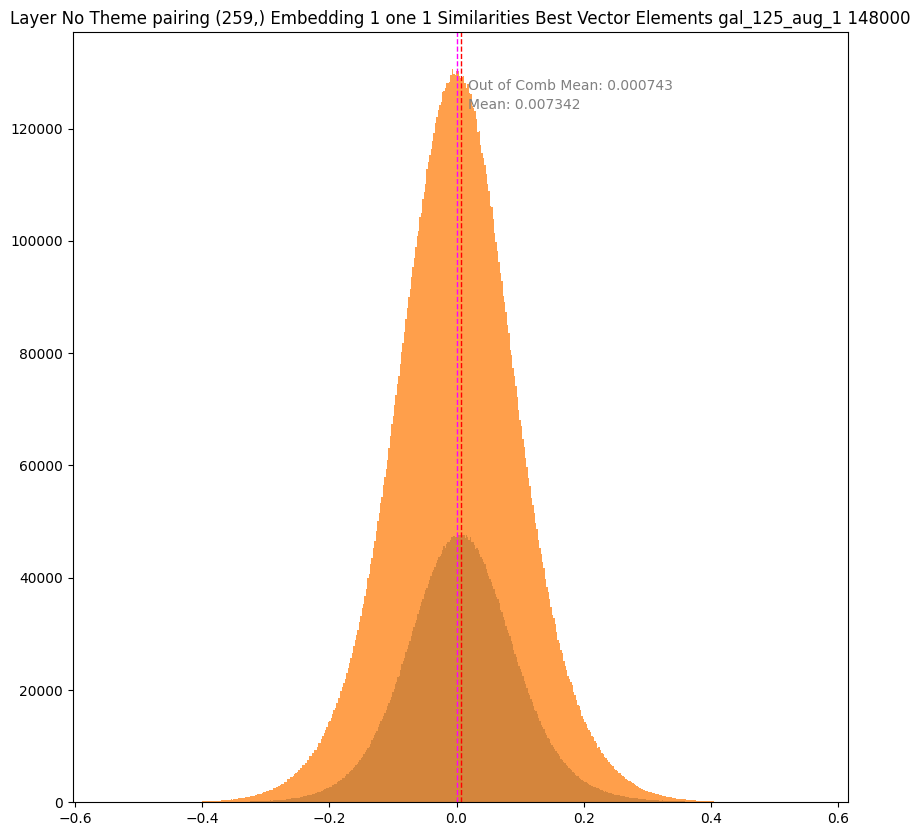

In [57]:
layer_n = f'No Theme pairing {vectors_a[0].shape}'
# Plotting all out of comb similarities vs all in comb similarities (combined)
all_in_comb = []
all_out_comb = []
for comb_dict in in_combination_comparisons.values():
    all_in_comb.extend(comb_dict['Cosine Similarities'])
    all_out_comb.extend(comb_dict['Out of Comb Simis'])

all_in_comb = np.array(all_in_comb)
all_out_comb = np.array(all_out_comb)
mean_in = np.mean(all_in_comb)
mean_out = np.mean(all_out_comb)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[10, 10])


axs.hist(all_in_comb, bins=500, alpha=0.75)
axs.hist(all_out_comb, bins=500, alpha=0.75)
axs.axvline(mean_in , color='red', linestyle='dashed', linewidth=1)
axs.axvline(mean_out, color='magenta', linestyle='dashed', linewidth=1)
axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.9, f'Mean: {mean_in:.6f}', color='grey')
axs.text(mean_in + 0.01, axs.get_ylim()[1] * 0.925, f'Out of Comb Mean: {mean_out:.6f}', color='grey')
axs.set_title(f'Layer {layer_n} Embedding 1 one 1 Similarities Best Vector Elements {model_name} {checkpoint}')
plt.show()
fig.savefig(f'{model_folder}/{layer_n} Output Embeddings Similarities {model_name} {checkpoint}')

In [ ]:
# The cosine similarities are  plotted

fig, axs = plt.subplots(nrows = len(in_combination_comparisons), ncols=1, figsize=[10, 500])
for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(i, end='\r')
    simis = np.array(combination_dict['Cosine Similarities'])
    
    axs[i].hist(simis, bins=100)
    axs[i].set_title(key)
    mean =  np.mean(simis)
  
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=1)
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.9, f'Mean: {mean:.6f}', color='red')
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.85, f'Number of Comparisons: {len(simis)}', color='orange')

plt.show()

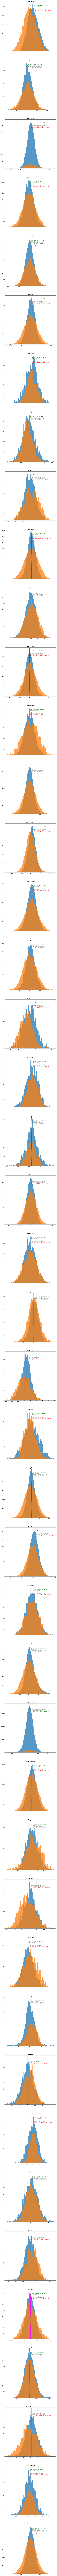

In [58]:
# Plotting the out of comb similarities

fig, axs = plt.subplots(nrows = len(in_combination_comparisons), ncols=1, figsize=[10, 500])
for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
    print(i, end='\r')
    simis = np.array(combination_dict['Cosine Similarities'])
    out_simis = np.array(combination_dict['Out of Comb Simis'])
    # Pruning the out of comb similarities to the same length as the similarities
    out_simis = out_simis
    
    mean_top_100 = np.mean(np.sort(simis)[-100:])
    out_mean_top_100 = np.mean(np.sort(out_simis)[-100:])
    
    axs[i].hist(simis, bins=100, alpha=.75)
    axs[i].hist(out_simis[:len(simis)], bins=100, alpha=.75)
    axs[i].set_title(key)
    mean =  np.mean(simis)
    mean_out = np.mean(out_simis)
  
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean_out, color='magenta', linestyle='dashed', linewidth=1)
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.9, f'Mean: {mean:.6f}', color='grey')
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.925, f'Out of Comb Mean: {mean_out:.6f}', 
                color='green' if mean > mean_out else 'red')
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.875, f'Number of Comparisons: {len(simis)}', color='grey')
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.85, f'Mean of Top 100: {mean_top_100:.6f}', color='grey')
    axs[i].text(mean + 0.01, axs[i].get_ylim()[1] * 0.825, f'Mean of Top 100 Out of Comb: {out_mean_top_100:.6f}', 
                color='green' if mean_top_100 > out_mean_top_100 else 'red')
    

plt.show()

# Dropping Vector Entries to Analyze their Influence on the Cosine Similarity

In [49]:
base_simi =  np.mean(np.array(in_combination_comparisons['iron_steel']['Cosine Similarities']))
#base_simi = mean_in
print('Base Metal wood Similarity', base_simi)

def test(drop_idx):
    emb = out_emb_dict
    combination_to_test = 'iron_steel'
    #layer_n = 13
    #emb = context_less_dicts[layer_n]
    # Dictionary that contains all differences and additional information for each material combination
    differences = {}
    # Huge dict, that contains the difference vectors as keys and 
    diffs_dict = {}
    
    for i, combination in enumerate(material_combinations.items()):
        key, item = combination
        # Checking if the reverse combination was already calculated
        current_material_keys = []
        for current_key in differences.keys():
          
            current_material_keys.append(current_key.split('_'))
        combination_keys = key.split('_')
        combination_keys.reverse()
        if combination_keys in current_material_keys:
            continue
    
        # Calculating the differences and storing them in a list of dict
        combinations_list = []
        for viewpoint_comb in item:
            viewpoint, mat_1, mat_2 = viewpoint_comb
            for f_term_1 in mat_1:
                for f_term_2 in mat_2:
                    try: 
                        
                        vec_1 = emb[f_term_1]
                        vec_2 = emb[f_term_2]
                        diff = vec_2 - vec_1
                        diff = normalize(np.array([diff]))[0]
                        sample_dict = {}
                        sample_dict['Vector'] = diff
                        sample_dict['Viewpoint'] = viewpoint
                        sample_dict['F-Term 1'] = f_term_1
                        sample_dict['F-Term 2'] = f_term_2
                        diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                        combinations_list.append(sample_dict)
                    except KeyError:
                        continue
        # Now the differences are computed and stored in a list of dicts
                
        differences[key] = combinations_list 
        
    # Dropping the vector entries at the drop index position 
    for key, comb_list in differences.items():
        for comb in comb_list:
            comb['Vector'] = np.delete(comb['Vector'], drop_idx, axis=0)
        
    # Pairing the vectors to compare
    
    max_comb = 100000000
    sqr_max_comb = int(max_comb**0.5)
    in_combination_comparisons = {}
    
    for i, [keys, samples] in enumerate(differences.items()):
        if keys != combination_to_test:
            if combination_to_test == 'all':
                pass
            else:
                # We just want to test a single material combination
                continue
        # Adding the comparison of the material combination with itself to the comparisons
        in_combination_comparisons[keys] = {'Vectors A': [], 
                                            'Vectors B': [],
                                            'Viewpoints': [],
                                            'F-Terms A': [],
                                            'F-Terms B': []}
     
        samples_2 = list(samples)
        random.shuffle(samples_2)
        s1 = 0 
        while len(samples_2) > 0:
            s1 += 1
            s2 = 0
            sample_a = samples_2.pop(0)
            random.shuffle(samples_2)
            for sample_b in samples_2:
    
                if s2 == sqr_max_comb:
                    break
                # Ignoring combinations with matching Viewpoints
                if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                    continue
                in_combination_comparisons[keys]['Vectors A'].append(torch.tensor(np.array([sample_a['Vector']])))
                in_combination_comparisons[keys]['Vectors B'].append(torch.tensor(np.array([sample_b['Vector']])))
                in_combination_comparisons[keys]['Viewpoints'].append([sample_a['Viewpoint'], sample_a['Viewpoint']])
                in_combination_comparisons[keys]['F-Terms A'].append([sample_a['F-Term 1'], sample_a['F-Term 2']])
                in_combination_comparisons[keys]['F-Terms B'].append([sample_b['F-Term 1'], sample_b['F-Term 2']])
                s2 += 1
            if s1 == sqr_max_comb:
                break
    # Calculating the Cosine Similarities within all combinations
    cos = torch.nn.CosineSimilarity(dim =1)
    bad_keys = []
    min_comb = 2000
    for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):
     
        try:
            similarities = cos(torch.cat(combination_dict['Vectors A'], 0), torch.cat(combination_dict['Vectors B'], 0))
            # Dropping combinations with low sample counts
            if len(similarities) < min_comb:
                bad_keys.append(key)
                continue
            combination_dict['Cosine Similarities'] = np.array(similarities)
            # Creating a sorted index of the similariteis to compare the best ones with other combinations
            combination_dict['Sort idx'] = np.argsort(np.array(similarities))[::-1]
            
            
        except RuntimeError:
      
            bad_keys.append(key)
            continue
        
    all_simis = []
    for comb_dict in in_combination_comparisons.values():
        try:
            all_simis.extend(comb_dict['Cosine Similarities'])
        except KeyError:
            continue
 
    
    print(f'Drop Index: {drop_idx} Mean in Combination Similarity: {np.mean(all_simis):.6f} Base Similarity: {base_simi:.6f}''', end= '\r')

    return all_simis


Base Metal wood Similarity -0.0018490097


In [50]:
vec_item_drop_simis = {layer: test(layer) for layer in range(768)}

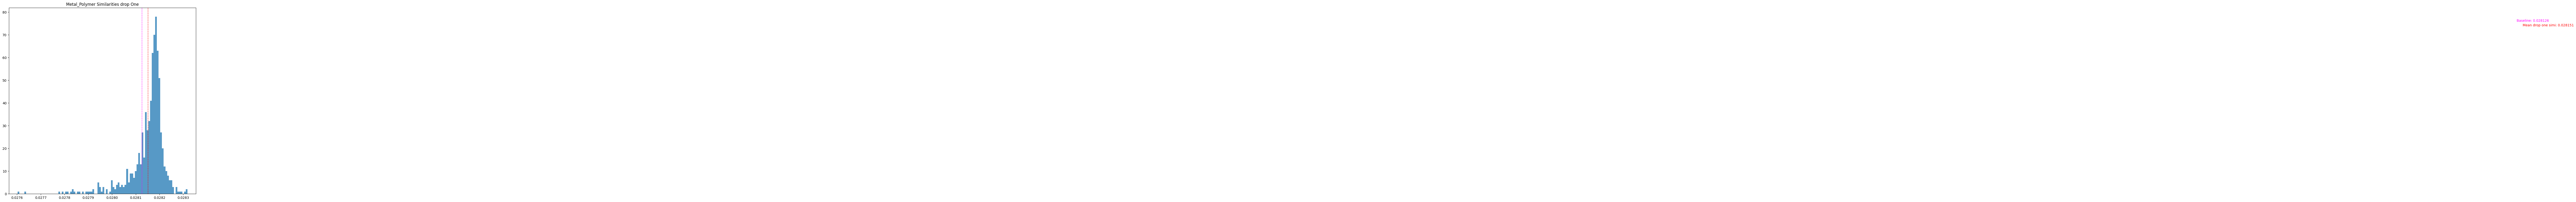

In [48]:
# Plotting the mean similarities for all vector element drop experiments

mean_simis = [np.mean(simis) for simis in vec_item_drop_simis.values()]
mean_mean_simis = np.mean(mean_simis)

fig, axs = plt.subplots(nrows = 1, ncols=1, figsize=[10, 10])    
axs.hist(mean_simis, bins=100, alpha=.75)

axs.set_title('Metal_Polymer Similarities drop One')

  
axs.axvline(mean_mean_simis, color='red', linestyle='dashed', linewidth=1)
axs.axvline(base_simi, color='magenta', linestyle='dashed', linewidth=1)
axs.text(mean_mean_simis + 0.01, axs.get_ylim()[1] * 0.9, f'Mean drop one simi: {mean_mean_simis:.6f}', color='red')
axs.text(base_simi + 0.01, axs.get_ylim()[1] * 0.925, f'Baseline: {base_simi:.6f}', color='magenta')

fig.savefig('Drop One Element in Metal Polymer Embeddings.png')
plt.show()

In [39]:
# extracting the vector indices, which are good for the cosine similarity within a cluster
keep_idxs = [i for i in range(len(mean_simis)) if mean_simis[i] < mean_mean_simis ]
len(keep_idxs)

259

In [ ]:
fig, axs = plt.subplots(nrows = 8, ncols=1, figsize=[5, 40]) 
cos = torch.nn.CosineSimilarity(dim =1)
for j, i in enumerate(range(100, 801, 100)):
    print(i)
    a = torch.randn(100000, i)
    b = torch.randn(100000, i)
    s = cos(a, b)
    axs[j].hist(s, bins=500)
    axs[j].set_title(i)
plt.show()

In [ ]:
# Calculating the best out of combination Similarities for all material combinations

results = []

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):

    # Generating the Best Match List
    out_simis = combination_dict['Out of Comb Simis']
    top_vecs = combination_dict['Out of Comb Vec A']
    out_vecs = combination_dict['Out of Comb Vec B']
    
    # Taking the highest n out of Combination Similarities
    n = 20
    idx = np.argsort(out_simis)[-n:]
    
    for id in idx:
        top_vec = top_vecs[id]
        out_vec = out_vecs[id]
        
        viewpoint_top, f_term1_top, f_term2_top = diffs_dict[str(np.sum(top_vec))]
        viewpoint_out, f_term1_out, f_term2_out = diffs_dict[str(np.sum(out_vec))]

        vp_top_desc = viewpoint_dict[viewpoint_top]
        vp_out_desc = viewpoint_dict[viewpoint_out]

        theme_top = theme_dict[viewpoint_top.split('/')[0]]
        theme_out = theme_dict[viewpoint_out.split('/')[0]]

        f_terms_top = [f_term1_top, f_term2_top]
        f_terms_out = [f_term1_out, f_term2_out]

        f_terms_top_desc = [number_dict[f_term1_top], number_dict[f_term2_top]]
        f_terms_out_desc = [number_dict[f_term1_out], number_dict[f_term2_out]]
        
        row_dict = {}
        row_dict['Material Combination'] = key.replace('_', '-')
        row_dict['Cosine Similarity'] = out_simis[id]
        row_dict['Viewpoint Top Vec'] = viewpoint_top
        row_dict['Description Viewpoint Top Vec'] = vp_top_desc
        row_dict['Theme Top Vec'] = theme_top
        row_dict['Viewpoint Out'] = viewpoint_out
        row_dict['Description Viewpoint Out'] = vp_out_desc
        row_dict['F-Terms Top A-B'] = f_terms_top
        row_dict['F-Terms Top A-B Description'] = f_terms_top_desc
        row_dict['F-Terms Out A-B'] = f_terms_out
        row_dict['F-Terms Out A-B Description'] = f_terms_out_desc
        results.append(row_dict)

results = pd.DataFrame(results)
results.to_excel(f'{model_folder}/Best out of combination similarities.xlsx')
results

In [ ]:
# Calculating the best out of combination Similarities for all material combinations

results = []

for i, (key, combination_dict) in enumerate(in_combination_comparisons.items()):

    # Generating the Best Match List
    out_simis = combination_dict['Out of Comb Simis']
    top_vecs = combination_dict['Out of Comb Vec A']
    out_vecs = combination_dict['Out of Comb Vec B']
    
    # Taking the highest n out of Combination Similarities
    n = 20
    idx = np.argsort(out_simis)[:n]
    
    for id in idx:
        top_vec = top_vecs[id]
        out_vec = out_vecs[id]
        
        viewpoint_top, f_term1_top, f_term2_top = diffs_dict[str(np.sum(top_vec))]
        viewpoint_out, f_term1_out, f_term2_out = diffs_dict[str(np.sum(out_vec))]

        vp_top_desc = viewpoint_dict[viewpoint_top]
        vp_out_desc = viewpoint_dict[viewpoint_out]

        theme_top = theme_dict[viewpoint_top.split('/')[0]]
        theme_out = theme_dict[viewpoint_out.split('/')[0]]

        f_terms_top = [f_term1_top, f_term2_top]
        f_terms_out = [f_term1_out, f_term2_out]

        f_terms_top_desc = [number_dict[f_term1_top], number_dict[f_term2_top]]
        f_terms_out_desc = [number_dict[f_term1_out], number_dict[f_term2_out]]
        
        row_dict = {}
        row_dict['Material Combination'] = key.replace('_', '-')
        row_dict['Cosine Similarity'] = out_simis[id]
        row_dict['Viewpoint Top Vec'] = viewpoint_top
        row_dict['Description Viewpoint Top Vec'] = vp_top_desc
        row_dict['Theme Top Vec'] = theme_top
        row_dict['Viewpoint Out'] = viewpoint_out
        row_dict['Description Viewpoint Out'] = vp_out_desc
        row_dict['F-Terms Top A-B'] = f_terms_top
        row_dict['F-Terms Top A-B Description'] = f_terms_top_desc
        row_dict['F-Terms Out A-B'] = f_terms_out
        row_dict['F-Terms Out A-B Description'] = f_terms_out_desc
        results.append(row_dict)

results = pd.DataFrame(results)
results.to_excel(f'{model_folder}/Worst out of combination similarities.xlsx')
results

In [ ]:
sort_max_simis = np.argsort(max_simis)
sort_max_simis = sort_max_simis[::-1]
top_50 = []
for i, idx in enumerate(sort_max_simis[:50]):
    output_dict = {}
    desc = max_simis_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = max_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    top_50.append(output_dict)

top_50 = pd.DataFrame(top_50)
top_50.to_csv('top_50.csv')
top_50

# Averaging the Material Vectors to Cancel out Theme and Viewpoint Specific Attributes.

In [ ]:
p = False
em = out_emb_dict

all_cos_base = []
all_cos_add = []
all_cos_diff = []
all_dist_base = []
all_dist_add = []
all_dist_diff = []


for i, (comb_name, samples) in enumerate(material_combinations.items()):
    # Creating tensors with all embeddings fo a certain combination
    emb_mat_1 = {}
    emb_mat_2 = {}
    viewpoints = []
    for viewpoint, samples_mat_1, samples_mat_2 in samples:
        emb_1_vp = []
        emb_2_vp = []
        # Extracting the vector embeddings for the first material
        for f_term in samples_mat_1:
            try:
                vec = em[f_term]
                emb_1_vp.append(vec)
            except KeyError:
                continue

        # Dropping the viewpoint if for the first material not a single vector is found
        if len(emb_1_vp) == 0:
            continue

        # Extracting the vector embeddings for the second material 
        for f_term in samples_mat_2:
            try: 
                vec = em[f_term]
                emb_2_vp.append(vec)
            except KeyError:
                continue

        # Dropping the viewpoint if for the second material not a single vector is found
        if len(emb_2_vp) == 0:
            continue

        # Adding the vector embeddings to the dicts
        emb_mat_1[viewpoint] = emb_1_vp
        emb_mat_2[viewpoint] = emb_2_vp 
        viewpoints.append(viewpoint)
        
    if len(emb_mat_1) < 2 or len(emb_mat_2) < 2:
        continue
    
    # Testing the predictive capabilities of diff mean vec (excluding the tested vector) + test_vector mat1 = test_vector mat2
    for viewpoint in viewpoints:
        # Creating copys of the dictionaries to be able to iterate over multiple viewpoints.
        emb_mat_1c = emb_mat_1.copy()
        emb_mat_2c = emb_mat_2.copy()
        # Removing the test viepoint embeddigns from the dict copy and storing them seperately
        test_vec_1 = emb_mat_1c.pop(viewpoint)[0]
        test_vec_2 = emb_mat_2c.pop(viewpoint)[0]
        # Creating the mean-vectors for material-1 and material-2
        mean_emb1 = []
        mean_emb2 = []
        for vecs1 in emb_mat_1c.values():
            mean_emb1.extend(vecs1)
        for vecs2 in emb_mat_2c.values():
            mean_emb2.extend(vecs2)
        
        mean_emb1 = np.stack(mean_emb1)
        mean_emb2 = np.stack(mean_emb2)
        mean_emb1 = np.mean(mean_emb1, 0)
        mean_emb2 = np.mean(mean_emb2, 0)
        diff = mean_emb2 - mean_emb1
        #diff = torch.nn.functional.normalize(torch.tensor([diff]), p=2).numpy().flatten()

        
        test_vec_1_2 = np.array(test_vec_1) + diff
        #test_vec_1_2 = torch.nn.functional.normalize(torch.tensor([test_vec_1_2]), p=2).numpy().flatten()

        cosim_1_2 = np.dot(test_vec_1, test_vec_2) / (np.linalg.norm(test_vec_1) * np.linalg.norm(test_vec_2))
        cosim_1_2_2 = np.dot(test_vec_1_2, test_vec_2) / (np.linalg.norm(test_vec_1_2) * np.linalg.norm(test_vec_2))
        
        dist_1_2 = distance.euclidean(test_vec_1, test_vec_2)
        dist_1_2_2 = distance.euclidean(test_vec_1_2, test_vec_2)

        all_cos_diff.append(cosim_1_2_2 - cosim_1_2)
        all_dist_diff.append(dist_1_2_2 - dist_1_2)
        all_cos_base.append(cosim_1_2)
        all_cos_add.append(cosim_1_2_2)
        all_dist_base.append(dist_1_2)
        all_dist_add.append(dist_1_2_2)
        if p:
            print(f'''
{comb_name}
Test-Viewpoint: {viewpoint}
        Cos (base):  {cosim_1_2:.5f}
        Cos (add):   {cosim_1_2_2:.5f}
        !!Cos (diff):  {cosim_1_2_2 - cosim_1_2:.5f}

        Dist (base): {dist_1_2:.5f}
        Dist (add):  {dist_1_2_2:.5f}
        !!Dist (diff): {dist_1_2_2 - dist_1_2:.5f}

Averages:
 Av Cos (base):      {np.mean(all_cos_base)}
 Av Cos (add):       {np.mean(all_cos_add)}
 !!Av Cos (diff):      {np.mean(all_cos_diff)}
 Av Dist (base):     {np.mean(all_dist_base)}
 Av Dist (add):      {np.mean(all_dist_add)}
 !!Av Dist (diff):     {np.mean(all_dist_diff)}
--------------------------------------------------------------------------------------- 
        ''')


In [ ]:
plt.hist(all_cos_diff, bins=100)
plt.show()

In [ ]:
plt.hist(all_dist_diff, bins=100)
plt.show()

In [ ]:
plt.hist(all_cos_base, alpha=0.5, label='base', bins=100)
plt.hist(all_cos_add, alpha=0.5, label='Vector_addition', bins=100)
plt.legend()
plt.show()


In [ ]:
plt.hist(all_dist_base, alpha=0.5, label='base', bins=100)
plt.hist(all_dist_add, alpha=0.5, label='add', bins=100)
plt.legend()
plt.show()

# Comparing the Cosine Similarities of all Vector Combinations

In [ ]:

# Generating the 1 on 1 differences for a single material combination
combination = material_combinations['metal_glass']
descriptions = []
diffs = []

for viewpoint, fterms1, fterms2 in combination:
    for fterm1 in fterms1:
        for fterm2 in fterms2:
            try: 
                vec1 = out_emb_dict[fterm1]
                vec2 = out_emb_dict[fterm2]
            except KeyError:
                continue

            diffs.append(vec2- vec1)
            descriptions.append([viewpoint, fterm1, fterm2])

descriptions = np.array(descriptions)
diffs = torch.tensor(diffs)

# Generating the cosine similarities

cos = torch.nn.CosineSimilarity(dim =1)

diffs = torch.tensor(normalize(diffs))
diffs1 = diffs.unsqueeze(0)
diffs2 = diffs.unsqueeze(1)
desc1 = np.expand_dims(descriptions, 0)
desc2 = np.expand_dims(descriptions, 1)
diffs1 = diffs1.expand(diffs.shape[0], diffs.shape[0], diffs.shape[1]).flatten(end_dim=-2)
diffs2 = diffs2.expand(diffs.shape[0], diffs.shape[0], diffs.shape[1]).flatten(end_dim=-2)
desc1 = np.broadcast_to(desc1, [descriptions.shape[0], descriptions.shape[0], descriptions.shape[1]]).reshape(-1, desc1.shape[-1])
desc2 = np.broadcast_to(desc2, [descriptions.shape[0], descriptions.shape[0], descriptions.shape[1]]).reshape(-1, desc2.shape[-1])

desc = np.stack([desc1, desc2],-1)


co_simis = cos(diffs1, diffs2)


In [ ]:
# sorting the similarities
sort_out = torch.argsort(co_simis)

# Removing 'wrong' similarities
clean_sort_simis = []
clean_desc = []

for idx in sort_out:
    simi = co_simis[idx]
    des = desc[idx]
    vp_a, vp_b = des[0]
    if vp_a == vp_b:
        continue
    clean_desc.append(des)
    clean_sort_simis.append(simi)



In [ ]:
plt.hist(clean_sort_simis, bins = 100)
#plt.hist(co_simis, bins=100)
plt.show()

In [ ]:
max_simis = []
min_simis = []
max_50_simis = []
min_50_simis = []
max_50_desc = []
min_50_desc = []
mean_simis = []
max_simis_desc = []
min_simis_desc = []
n_comb = []

for i, pair  in enumerate(material_combinations.items()):
    name, combination = pair
    descriptions = []
    diffs = []
    
    for viewpoint, fterms1, fterms2 in combination:
        for fterm1 in fterms1:
            for fterm2 in fterms2:
                try: 
                    vec1 = out_emb_dict[fterm1]
                    vec2 = out_emb_dict[fterm2]
                except KeyError:
                    continue
    
                diffs.append(vec2- vec1)
                descriptions.append([viewpoint, fterm1, fterm2, name])
    
    descriptions = np.array(descriptions)
    diffs = torch.tensor(diffs)
    
    # Generating the cosine similarities
    
    cos = torch.nn.CosineSimilarity(dim =1)
    try:
        diffs = torch.nn.functional.normalize(diffs, p=2, dim=1)
    except IndexError:
        continue
        
    diffs1 = diffs.unsqueeze(0)
    diffs2 = diffs.unsqueeze(1)
    desc1 = np.expand_dims(descriptions, 0)
    desc2 = np.expand_dims(descriptions, 1)
    diffs1 = diffs1.expand(diffs.shape[0], diffs.shape[0], diffs.shape[1]).flatten(end_dim=-2)
    diffs2 = diffs2.expand(diffs.shape[0], diffs.shape[0], diffs.shape[1]).flatten(end_dim=-2)
    desc1 = np.broadcast_to(desc1, [descriptions.shape[0], descriptions.shape[0], descriptions.shape[1]]).reshape(-1, desc1.shape[-1])
    desc2 = np.broadcast_to(desc2, [descriptions.shape[0], descriptions.shape[0], descriptions.shape[1]]).reshape(-1, desc2.shape[-1])
    
    desc = np.stack([desc1, desc2],-1)
    
    co_simis = cos(diffs1, diffs2)

    # sorting the similarities
    sort_out = torch.argsort(co_simis)
    
    # Removing 'wrong' similarities (cosine similarities where the theme is identical for both vector differences)
    clean_sort_simis = []
    clean_desc = []
    
    for idx in sort_out:
        simi = co_simis[idx]
        des = desc[idx]
        vp_a, vp_b = des[0]
        # Removing Comparisons within the same Viewpoint
        if vp_a == vp_b:
            continue
        clean_desc.append(des)
        clean_sort_simis.append(simi)
    try:
        
        max_simis.append(clean_sort_simis[-1])
        min_simis.append(clean_sort_simis[0])
        max_50_simis.extend(clean_sort_simis[-50:])
        min_50_simis.extend(clean_sort_simis[:50])
        max_50_desc.extend(clean_desc[-50:])
        min_50_desc.extend(clean_desc[:50])

        mean_simis.append(np.mean(clean_sort_simis))
        max_simis_desc.append(clean_desc[-1])
        min_simis_desc.append(clean_desc[0])
        n_comb.append(len(sort_out))
    except IndexError:
        continue

    print(f'{i}  {name} max: {max_simis[-1]}, min: {min_simis[-1]}, mean: {mean_simis[-1]}, mean_max: {np.mean(max_simis)}, mean_min: {np.mean(min_simis)} mean_mean: {np.sum(np.array(mean_simis)*np.array(n_comb))/np.sum(n_comb)}', end='\r')


In [ ]:
sort_max_simis = np.argsort(max_simis)
sort_max_simis = sort_max_simis[::-1]
top_50 = []
for i, idx in enumerate(sort_max_simis[:50]):
    output_dict = {}
    desc = max_simis_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = max_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    top_50.append(output_dict)

top_50 = pd.DataFrame(top_50)
top_50.to_csv('top_50.csv')
top_50

In [ ]:
sort_min_simis = np.argsort(min_simis)

worst_50 = []
for i, idx in enumerate(sort_min_simis[:50]):
    output_dict = {}
    desc = min_simis_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = min_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    worst_50.append(output_dict)

worst_50 = pd.DataFrame(worst_50)
worst_50.to_csv('worst_50.csv')
worst_50

In [ ]:
sort_max_simis = np.argsort(max_50_simis)
sort_max_simis = sort_max_simis[::-1]
top_50_overall = []
for i, idx in enumerate(sort_max_simis[:50]):
    output_dict = {}
    desc = max_50_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = max_50_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    top_50_overall.append(output_dict)

top_50_overall = pd.DataFrame(top_50_overall)
top_50_overall.to_csv('top_50_overall.csv')
top_50_overall

In [ ]:
sort_max_simis = np.argsort(min_50_simis)
sort_max_simis = sort_max_simis[::-1]
top_50_overall = []
for i, idx in enumerate(sort_max_simis[:50]):
    output_dict = {}
    desc = max_50_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = max_50_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    top_50_overall.append(output_dict)

top_50_overall = pd.DataFrame(top_50_overall)
top_50_overall.to_csv('top_50_overall.csv')
top_50_overall

In [ ]:
sort_min_simis = np.argsort(min_50_simis)
worst_50_overall = []

for i, idx in enumerate(sort_min_simis[:50]):
    output_dict = {}
    desc = min_50_desc[idx]
    output_dict['Combination'] = desc[-1][0].replace('_', '-')
    output_dict['Cosine Similarity'] = min_50_simis[idx].item()
    output_dict['Viewpoint 1'] = desc[0][0]
    output_dict['Viewpoint 1 Description'] = viewpoint_dict[desc[0][0]]
    output_dict['Theme 1'] = theme_dict[desc[0][0].split('/')[0]]
    output_dict['Viewpoint 2'] = desc[0][1]
    output_dict['Viewpoint 2 Description'] = viewpoint_dict[desc[0][1]]
    output_dict['Theme 2'] = theme_dict[desc[0][1].split('/')[0]]
    output_dict['F-Terms Vector 1'] = [desc[1][0].tolist(), desc[2][0].tolist()]
    output_dict['F-Terms Vector 1 Description'] = 'Description a: ' + number_dict[desc[1][0]] + '     Description b: ' + number_dict[desc[2][0]]
    output_dict['F-Terms Vector 2'] = [desc[1][1].tolist(), desc[2][1].tolist()]
    output_dict['F-Terms Vector 2 Description'] = 'Description a: ' + number_dict[desc[1][1]] + '     Description b: ' + number_dict[desc[2][1]]
    worst_50_overall.append(output_dict)

worst_50_overall = pd.DataFrame(worst_50_overall)
worst_50_overall.to_csv('worst_50_overall.csv')
worst_50_overall

# Optimizing a Filter to extract the meaningfull Information form Material Combination Difference Vectors

In [ ]:
# Recreating the vector differences 

emb = out_emb_dict
#layer_n = 13
#emb = context_less_dicts[layer_n]
# Dictionary that contains all differences and additional information for each material combination
differences = {}
# Huge dict, that contains the difference vectors as keys and 
diffs_dict = {}

for i, combination in enumerate(material_combinations.items()):
    key, item = combination
    print(i, key, end='\r')
    # Checking if the reverse combination was already calculated
    current_material_keys = []
    for current_key in differences.keys():
      
        current_material_keys.append(current_key.split('_'))
    combination_keys = key.split('_')
    combination_keys.reverse()
    if combination_keys in current_material_keys:
        continue

    # Calculating the differences and storing them in a list of dict
    combinations_list = []
    for viewpoint_comb in item:
        viewpoint, mat_1, mat_2 = viewpoint_comb
        for f_term_1 in mat_1:
            for f_term_2 in mat_2:
                try: 
                    
                    vec_1 = emb[f_term_1]
                    vec_2 = emb[f_term_2]
                    diff = vec_2 - vec_1
                    diff = normalize(np.array([diff]))[0]
                    sample_dict = {}
                    sample_dict['Vector'] = diff
                    sample_dict['Viewpoint'] = viewpoint
                    sample_dict['F-Term 1'] = f_term_1
                    sample_dict['F-Term 2'] = f_term_2
                    diffs_dict[sys.intern(str(np.sum(diff)))] = [viewpoint, f_term_1, f_term_2]
                    combinations_list.append(sample_dict)
                except KeyError:
                    continue
    # Now the differences are computed and stored in a list of dicts
            
    differences[key] = combinations_list 

In [ ]:
# Generating two tensors with all combinations possible within a material combination, 
# Without matching viewpoints
matching_a, matching_b = [], []
for key, comb_list in differences.items():
    for i, comb1 in enumerate(comb_list):
        for comb2 in comb_list[i:]:
            vp1, vp2 = comb1['Viewpoint'], comb2['Viewpoint']
            if vp1 == vp2:
                continue
            matching_a.append(comb1['Vector'])
            matching_b.append(comb2['Vector'])
            
matching_idx = [i for i in range(len(matching_a))]
random.shuffle(matching_idx)

matching_a = np.stack(matching_a, 0)
matching_b = np.stack(matching_b, 0)
matching_a = matching_a[matching_idx]
matching_b = matching_b[matching_idx]

In [ ]:
# Generating not matching samples

class UnmatchingGenerator():
    def __init__(self):
        all_samples = []
        for key, comb_list in differences.items():
            for comb in comb_list:
                comb['Combination'] = key
                all_samples.append(comb)
        self.all_samples = all_samples
        self.range = np.arange(len(all_samples))

    def generate_unmatching(self, n_samples):
        # Can only generate as many samples as there are individual samples in self.all_samples
        if n_samples > len(self.all_samples):
            max_samples = len(self.all_samples) - 1
            outs_a = []
            outs_b = []
            for _ in range(n_samples//max_samples):
                outputs = self.generate_unmatching(max_samples)
                outs_a.append(outputs[0])
                outs_b.append(outputs[1])
            outputs = self.generate_unmatching(n_samples%max_samples)
            outs_a.append(outputs[0])
            outs_b.append(outputs[1])
            return np.concatenate(outs_a, 0), np.concatenate(outs_b, 0)
            
        np.random.shuffle(self.range)
        out_a, out_b = [], []
        for i in range(n_samples):
            sample_a = self.all_samples[self.range[i]]
            for idx in self.range:
                sample_b = self.all_samples[idx]

                if sample_a['Viewpoint'] == sample_b['Viewpoint']:
                    # No matching Viewpoints allowed
                    continue
                
                mat_a1, mat_a2 = sample_a['Combination'].split('_')
                mat_b1, mat_b2 = sample_b['Combination'].split('_')
                
                if mat_a1 in [mat_b1, mat_b2] or mat_a2 in [mat_b1, mat_b2]:
                    # no matching materials should be compared
                    continue
                out_a.append(sample_a['Vector'])
                out_b.append(sample_b['Vector'])
                break
        return np.stack(out_a, 0), np.stack(out_b, 0)
                

umg = UnmatchingGenerator()
unmatching_a, unmatching_b = umg.generate_unmatching(100)

unmatching_a.shape

In [ ]:
# Training a filter
epochs = 100
batch_size = 200000 
dev = 'cuda:0'

filter = torch.randn(768, requires_grad = True, device=dev)
sigm = torch.nn.functional.sigmoid
cos = torch.nn.CosineSimilarity(dim =1)
optimizer = torch.optim.SGD([filter], lr=1000)


# Initial Test Loop
wsum_test_loss = 0
for i in range(0, len(matching_a), batch_size):
    with torch.no_grad():
        batch_ma = torch.tensor(matching_a[i: i+ batch_size]).to(dev) 
        batch_mb = torch.tensor(matching_b[i: i+ batch_size]).to(dev)
        batch_uma, batch_umb = umg.generate_unmatching(batch_size)
        batch_uma = torch.tensor(batch_uma).to(dev)
        batch_umb = torch.tensor(batch_umb).to(dev)
    
        batch_ma = batch_ma * sigm(filter)
        batch_mb = batch_mb * sigm(filter)
        batch_uma = batch_uma * sigm(filter)
        batch_umb = batch_umb * sigm(filter)
            
        simi_matching = torch.mean(cos(batch_ma, batch_mb))
        simi_unmatching = torch.mean(cos(batch_uma,batch_umb))
        loss = simi_unmatching - simi_matching
        wsum_test_loss += loss*len(batch_ma)
        print(f'Samples computed:{ i + len(batch_ma)} Current Loss Test: {loss.item():.5f} Averate Loss Test: {wsum_test_loss/(i+len(batch_ma))}', end='\r')
print('')

# Training loop
for epoch in range(epochs):
    wsum_loss = 0
    for i in range(batch_size, len(matching_a), batch_size): 
        batch_ma = torch.tensor(matching_a[i: i+ batch_size]).to(dev) 
        batch_mb = torch.tensor(matching_b[i: i+ batch_size]).to(dev)
        batch_uma, batch_umb = umg.generate_unmatching(batch_size)
        batch_uma = torch.tensor(batch_uma).to(dev)
        batch_umb = torch.tensor(batch_umb).to(dev)
    

        batch_ma = batch_ma * sigm(filter)
        batch_mb = batch_mb * sigm(filter)
        batch_uma = batch_uma * sigm(filter)
        batch_umb = batch_umb * sigm(filter)
        
        simi_matching = torch.mean(cos(batch_ma, batch_mb))
        simi_unmatching = torch.mean(cos(batch_uma,batch_umb))
        loss = simi_unmatching - simi_matching
        wsum_loss += loss*len(batch_ma)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch: {epoch} Samples computed:{ i + len(batch_ma)} Current Loss Train: {loss.item():.6f} Averate Loss Epoch Train: {wsum_loss/(i+len(batch_ma)):.6f}, First Filter Value: {filter[0].item():.6f}', end='\r')

In [ ]:
sorted_filter = torch.sort(filter)
sorted_filter

# Calculating all in Viewpoint Combinations

In [ ]:
# Creating a dictionary that lists all viewpoints and their f-terms
vp_f_terms_dict = {}

for f_term in f_term_tokens:
    vp = f_term[:8]
    try:
        vp_f_terms_dict[vp].append(f_term)
    except KeyError:
        vp_f_terms_dict[vp] = [f_term]
    

In [ ]:
# Creating all vectors that point from one f-term to another in the viewpoint
all_combinations_dict = {}
all_diffs_dict = {}
for vp, vp_f_terms in vp_f_terms_dict.items():
    for i, f_term1 in enumerate(vp_f_terms, start=1):
        for f_term2 in vp_f_terms[i:]:
            try:
                all_combinations_dict[vp].append([f_term1, f_term2])
                all_diffs_dict[vp].append(out_emb_dict[f_term1[:-1]] - out_emb_dict[f_term2[:-1]])
            except KeyError:
                all_combinations_dict[vp] = [[f_term1, f_term2]]
                all_diffs_dict[vp] = [out_emb_dict[f_term1[:-1]] - out_emb_dict[f_term2[:-1]]]
    # Combining all differences within a viewpoint to a tensor 
    if len(vp_f_terms) != 1:  # No differences computed if just one f-term is present
        all_diffs_dict[vp] = np.stack(all_diffs_dict[vp], 0) 

len(all_diffs_dict) 

In [ ]:
for vp, deff in viewpoint_dict.items():
    break
print(vp, deff)

def generate_diff_tensor(viewpoint):
    """
    combines all differences and combinations except the queery viewpoint "viewpoint"
    """
    desc = []
    diffs = []
    for vp, combinations in all_combinations_dict.items():
        if vp == viewpoint:
            continue
        desc.extend(combinations)
        diffs.append(all_diffs_dict[vp])
    diffs = np.concatenate(diffs, 0)
    return desc, diffs

#desc, diffs = generate_diff_tensor('2B002/AA')
all_desc, all_diffs = generate_diff_tensor('')
all_diffs.shape

# Nearest Neighbors Search within all Differences

In [ ]:
all_nbrs = NearestNeighbors(n_neighbors = 100, algorithm = 'ball_tree').fit(all_diffs)

In [ ]:
n = 100042

distances, indices = all_nbrs.kneighbors(np.array([all_diffs[n]]))

number_dict[all_desc[n][0][:-1]], number_dict[all_desc[n][1][:-1]]

In [ ]:
for distance, ind in zip(distances[0], indices[0]):
    print('Distance', distance)
    f_term1, f_term2 = all_desc[ind]
    print('F-Terms',number_dict[f_term1[:-1]], number_dict[f_term2[:-1]])
    vp1, vp2 = f_term1[:8], f_term2[:8]
    print('Viewpoints', viewpoint_dict[vp1])
    print('---------------------------')


In [ ]:
indices.shape, distances.shape

In [ ]:
np.mean(np.sqrt(all_diffs[0]**2))

In [ ]:
np.mean(np.sqrt(out_emb[0]**2))

In [ ]:
np.mean(np.sqrt(out_emb**2))

# Calculating all in Theme Combinations

In [ ]:
# Calculating the needed combinations
theme_f_term_dict = {}
for f_term in f_term_tokens:
    theme = f_term.split('/')[0]
    try: 
        theme_f_term_dict[theme].append(f_term)
    except KeyError:
        theme_f_term_dict[theme] = [f_term]

n_combs = 0
for combs in theme_f_term_dict.values():
    n_combs += len(combs) * (len(combs)-1)

print(f'There are {n_combs} in theme combinations')

In [ ]:
theme_diffs = {}
theme_desc = {}
max_per_theme = 10000

for theme, f_terms in theme_f_term_dict.items():
    for i, f_term1 in enumerate(f_terms, start=1):
        for f_term2 in f_terms[i:]:
            
            try: 
                if len(theme_diffs[theme]) >= max_per_theme:
                    # Skipping some combinations to prevent memory overflow
                    break
                theme_diffs[theme].append(out_emb_dict[f_term1[:-1]] -out_emb_dict[f_term2[:-1]])
                theme_desc[theme].append([f_term1, f_term2])
                theme_diffs[theme].append(out_emb_dict[f_term2[:-1]] -out_emb_dict[f_term1[:-1]])
                theme_desc[theme].append([f_term2, f_term1])
            except KeyError:
                theme_diffs[theme] = [out_emb_dict[f_term1[:-1]] -out_emb_dict[f_term2[:-1]]]
                theme_desc[theme] = [[f_term1, f_term2]]
                theme_diffs[theme] = [out_emb_dict[f_term2[:-1]] -out_emb_dict[f_term1[:-1]]]
                theme_desc[theme] = [[f_term2, f_term1]]